# Youtube Transcript Search QA Bot

This Q&A bot will allow you to search through youtube transcripts using natural language! By going through this notebook, we'll introduce how you can use LanceDB to store and manage your data easily.


<a href="https://colab.research.google.com/github/lancedb/vectordb-recipes/blob/main/examples/youtube_bot/main.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">

Scripts - [![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)](./examples/youtube_bot/main.py)  [![JavaScript](https://img.shields.io/badge/javascript-%23323330.svg?style=for-the-badge&logo=javascript&logoColor=%23F7DF1E)](./examples/youtube_bot/index.js)


In [1]:
!pip install --quiet openai datasets
!pip install --quiet -U lancedb


[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


## Download the data

For this dataset we're using the HuggingFace dataset `jamescalam/youtube-transcriptions`.

From the [website](https://huggingface.co/datasets/jamescalam/youtube-transcriptions):

```
The YouTube transcriptions dataset contains technical tutorials (currently from James Briggs, Daniel Bourke, and AI Coffee Break) transcribed using OpenAI's Whisper (large). Each row represents roughly a sentence-length chunk of text alongside the video URL and timestamp.
```

We'll use the training split with 700 videos and 208619 sentences

In [2]:
from datasets import load_dataset

data = load_dataset('jamescalam/youtube-transcriptions', split='train')
data

Found cached dataset json (/Users/changshe/.cache/huggingface/datasets/jamescalam___json/jamescalam--youtube-transcriptions-08d889f6a5386b9b/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


Dataset({
    features: ['title', 'published', 'url', 'video_id', 'channel_id', 'id', 'text', 'start', 'end'],
    num_rows: 208619
})

## Prepare context

Each item in the dataset contains just a short chunk of text. We'll need to merge a bunch of these chunks together on a rolling basis. For this demo, we'll merge 20 rows and step over 4 rows at a time. LanceDB offers chaining support so you can write declarative, readable and parameterized queries. Here we serialize to Pandas as well:

In [3]:
from lancedb.context import contextualize

df = (contextualize(data.to_pandas())
      .groupby("title").text_col("text")
      .window(20).stride(4)
      .to_pandas())
df.head(1)

,title,published,url,video_id,channel_id,id,text,start,end
177622,$5 MILLION AI for FREE,2022-08-12 15:18:07,https://youtu.be/3EjtHs_lXnk,3EjtHs_lXnk,UCfzlCWGWYyIQ0aLC5w48gBQ,3EjtHs_lXnk-t0.0,Imagine an AI where all in the same model you ...,0.0,24.0


## Create embedding function
To create embeddings out of the text, we'll call the OpenAI embeddings API to get embeddings.
Make sure you have an API key setup and that your account has available credits.

In [4]:
from openai import OpenAI
import os

# Configuring the environment variable OPENAI_API_KEY
if "OPENAI_API_KEY" not in os.environ:
    # OR set the key here as a variable
    os.environ["OPENAI_API_KEY"] = "sk-..."

client = OpenAI()
assert len(client.models.list().data) > 0

We'll use the ada2 text embeddings model

In [5]:
def embed_func(c):
    rs = client.embeddings.create(input=c, model="text-embedding-ada-002")
    return [
        data.embedding
        for data in rs.data
    ]

## Create the LanceDB Table
OpenAI API often fails or times out. So LanceDB's API provides retry and throttling features behind the scenes to make it easier to call these APIs. In LanceDB the primary abstraction you'll use to work with your data is a Table. A Table is designed to store large numbers of columns and huge quantities of data! For those interested, a LanceDB is columnar-based, and uses Lance, an open data format to store data.

In [6]:
import lancedb
from lancedb.embeddings import with_embeddings

data = with_embeddings(embed_func, df, show_progress=True)
data.to_pandas().head(1)

  0%|          | 0/49 [00:00<?, ?it/s]

,title,published,url,video_id,channel_id,id,text,start,end,vector
0,$5 MILLION AI for FREE,2022-08-12 15:18:07,https://youtu.be/3EjtHs_lXnk,3EjtHs_lXnk,UCfzlCWGWYyIQ0aLC5w48gBQ,3EjtHs_lXnk-t0.0,Imagine an AI where all in the same model you ...,0.0,24.0,"[-0.02439424, -0.0007703846, 0.016625028, -0.0..."


Now we're ready to save the data and create a new LanceDB table

In [7]:
!rm -rf /tmp/lancedb

db = lancedb.connect("/tmp/lancedb")
tbl = db.create_table("chatbot", data)
len(tbl)

48935

The table is backed by a Lance dataset so it's easy to integrate into other tools (e.g., pandas)

In [8]:
tbl.to_pandas().head(1)

,title,published,url,video_id,channel_id,id,text,start,end,vector
0,$5 MILLION AI for FREE,2022-08-12 15:18:07,https://youtu.be/3EjtHs_lXnk,3EjtHs_lXnk,UCfzlCWGWYyIQ0aLC5w48gBQ,3EjtHs_lXnk-t0.0,Imagine an AI where all in the same model you ...,0.0,24.0,"[-0.02439424, -0.0007703846, 0.016625028, -0.0..."


## Create and answer the prompt

For a given context (bunch of text), we can ask the OpenAI Completion API to answer an arbitrary question using the following prompt:

In [9]:
def create_prompt(query, context):
    limit = 3750

    prompt_start = (
        "Answer the question based on the context below.\n\n"+
        "Context:\n"
    )
    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )
    # append contexts until hitting limit
    for i in range(1, len(context)):
        if len("\n\n---\n\n".join(context.text[:i])) >= limit:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(context.text[:i-1]) +
                prompt_end
            )
            break
        elif i == len(context)-1:
            prompt = (
                prompt_start +
                "\n\n---\n\n".join(context.text) +
                prompt_end
            )
    return prompt

In [10]:
def complete(prompt):
    res = client.completions.create(
        model='text-davinci-003',
        prompt=prompt,
        temperature=0,
        max_tokens=400,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return res.choices[0].text

# check that it works
query = "who was the 12th person on the moon and when did they land?"
complete(query)

'The 12th person on the moon was Harrison Schmitt, and he landed on December 11, 1972.'

## Let's put it all together now

In [11]:
query = ("Which training method should I use for sentence transformers "
         "when I only have pairs of related sentences?")

In [12]:
# Embed the question
emb = embed_func(query)[0]


Again we'll use LanceDB's chaining query API. This time, we'll perform similarity search to find similar embeddings to our query. We can easily tweak the parameters in the query to produce the best result.

In [13]:
# Use LanceDB to get top 3 most relevant context
context = tbl.search(emb).limit(3).to_pandas()

In [14]:
# Get the answer from completion API
prompt = create_prompt(query, context)
complete(prompt)

'NLI with multiple negative ranking loss.'

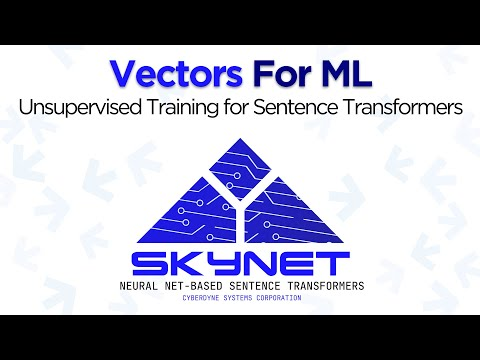

In [15]:
from IPython.display import YouTubeVideo

top_match = context.iloc[0]
YouTubeVideo(top_match["url"].split("/")[-1], start=int(top_match["start"]))